In [3]:
# calculate kiwifruit 's each parts' mua, mus, with Shape Approximation method
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
# from scipy import signal
# from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential

In [4]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [5]:
dict0 = {-1: 'Xiao_1206\\kiwi_center_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_skin.txt',1:'Xiao_1206\\kiwi_hard_skin.txt'}
dict1 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_skin.txt',1:'Xiao_1206\\kiwi_hard_skin.txt'}
dict2 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_flesh.txt',1:'Xiao_1206\\kiwi_hard_flesh.txt'}
dict3 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_center.txt',1:'Xiao_1206\\kiwi_hard_center.txt'}

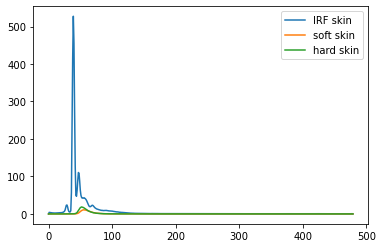

In [6]:
N = 3
scat = [None]*N
data_480multi9 = np.zeros((N,480), dtype = float)
for i in range(0,N):
    scat[i] = process_hyperspec(dict3[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index

line = [None]*N
plt.figure('ns/nm')
for i in range(0,N):
    line[i], = plt.plot(data_480multi9[i,:])

plt.legend(handles=[line[0],line[1],line[2]]
           ,labels=['IRF skin','soft skin','hard skin'],loc='best')
plt.show()
    

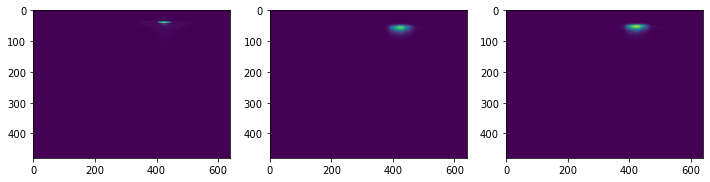

In [7]:
plt.figure(figsize= (12,3*12))
plt.subplot(1,3,1)
plt.imshow(scat[0].return_array())
plt.subplot(1,3,2)
plt.imshow(scat[1].return_array())
plt.subplot(1,3,3)
plt.imshow(scat[2].return_array())
plt.show()


In [8]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

In [9]:
data_intensity_extended = np.zeros((N, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]

In [10]:
h = smooth(data_480multi9[0,:]/max(data_480multi9[0,:]), 10) #x*h = y ; x.shape = (480,) h.shape = (480,) y.shape = (959,)


In [11]:
y =np.zeros((N,959))
for i in range(0,N):
    y[i,:] = smooth(data_intensity_extended[i,:]/max(data_intensity_extended[i,:]), 10)
    


In [12]:

    
class calculate_miu_s(object):
    
    def __init__(self, h, y, time_index):
        self.h = h
        self.y = y
        self.time = time_index
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_s = x[0]
        miu_a = x[1]
        # miu_a = 0.01e2
        g = 0.85
        d = 13.79e-3
        # t = 300e-12
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] - 1):

            intensity1[i] = calculate_miu_s.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.y_convolved = y2
        y2 = y2/max(y2)
        return np.sum(abs(y2-self.y))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        


In [15]:
miu_s_get = np.zeros((N-1,2))
m = [None]*(N-1)
for i in range(1,N):
    m[i-1] = calculate_miu_s(h, y[i], time_index)
    miu_s_get[i-1,:] = minimize(m[i-1].error_cal, x0 = [0.1,2], method  = 'Nelder-Mead', options={"xtol" : 1e-10, "disp":True}).x

Optimization terminated successfully.
         Current function value: 5.043657
         Iterations: 154
         Function evaluations: 288
Optimization terminated successfully.
         Current function value: 11.738209
         Iterations: 110
         Function evaluations: 206


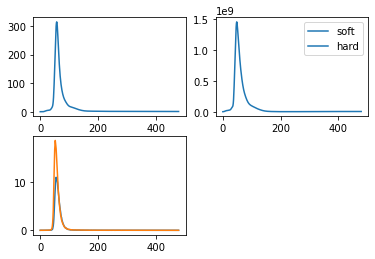

In [22]:
m = [None]*(N-1)
fitted = np.zeros((N-1,480))

plt.figure()
for i in range(0,(N-1)):
    m[i] = calculate_miu_s(h, y[i,:], time_index)
    m[i].error_cal(miu_s_get[i])
    fitted[i,] = m[i].get_convolved_signal()[0:480]

# plt.subplot(2,1,1)
# for i in range(0,(N-1)):
#     line[i], = plt.plot(fitted[i])

plt.subplot(2,2,1)
line[0], = plt.plot(fitted[0])

plt.subplot(2,2,2)
line[1], = plt.plot(fitted[1])

plt.legend(handles=[line[0],line[1]]
           ,labels=['soft','hard'],loc='best')
# m2.error_cal(x = [1.32009632, 0.83100736])
# plt.plot(m2.get_convolved_signal())

# m2.error_cal(x = [1.35795134, 0.37235146])

# plt.plot(m2.get_convolved_signal())
plt.subplot(2,2,3)
for i in range(1,N):
    plt.plot(data_480multi9[i,:])
    

plt.show()
# print(y2.shape,y.shape)

In [17]:
print(miu_s_get)

[[ 3.55129939 93.13362643]
 [ 0.40724731  2.02003515]]


In [166]:
print(miu_s_get)

[[6.34283707e-02 2.82894665e+04]
 [6.46020305e-02 1.93385030e+04]]
